# Tomato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

**Import all the Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

**Set all the Constants**

In [43]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

**Import data into tensorflow dataset object**

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [44]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomato-classi-16k/data_final",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 16011 files belonging to 10 classes.


In [45]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(64, 256, 256, 3)
(64,)


In [46]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

**Visualize some of the images from our dataset**

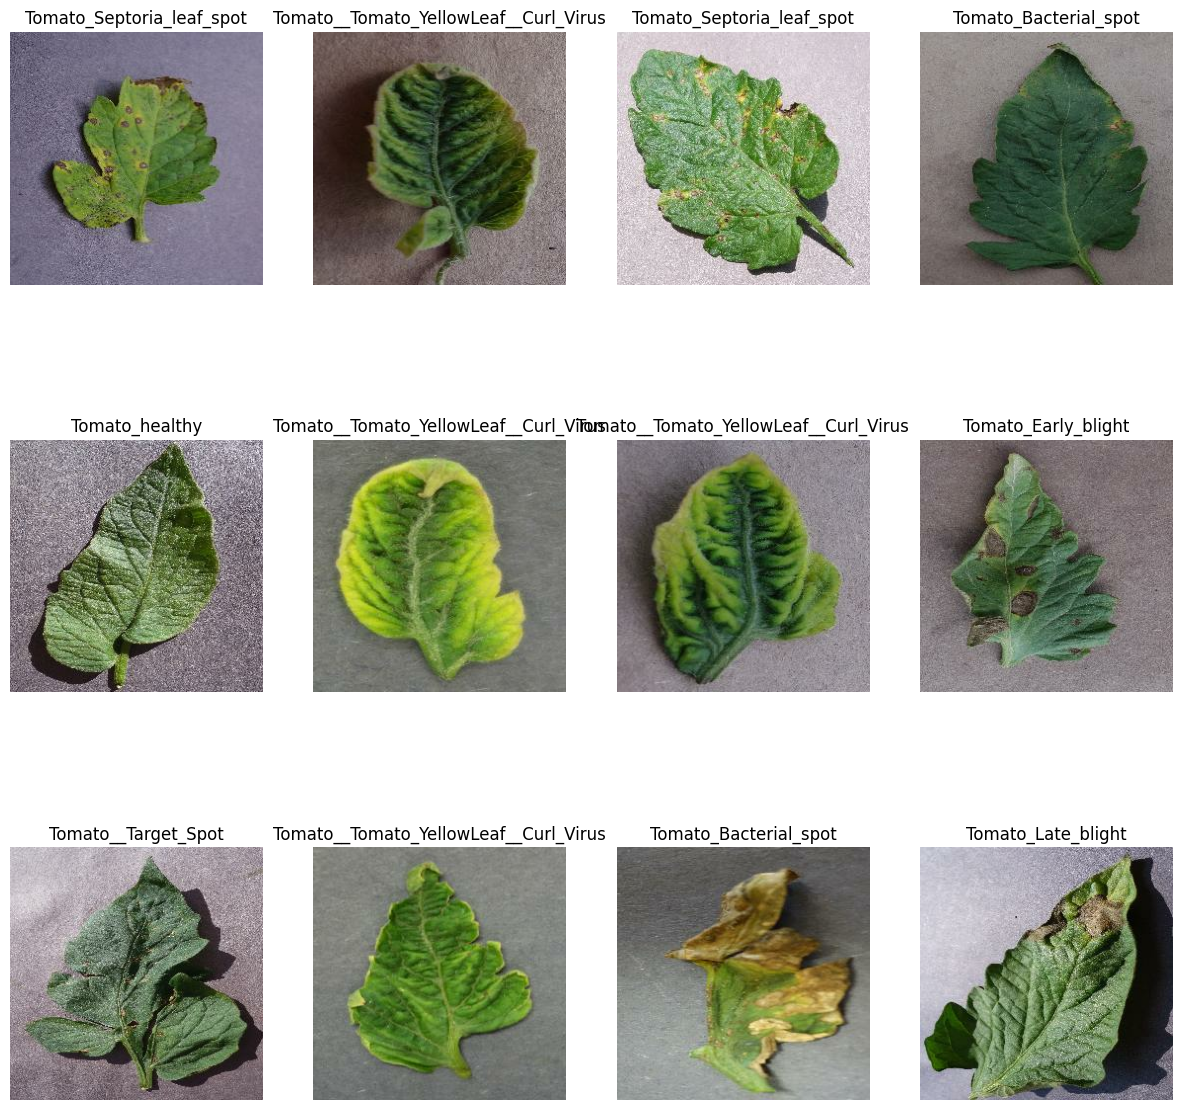

In [47]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset

**Dataset should be bifurcated into 3 subsets, namely:**

Training: Dataset to be used while training
Validation: Dataset to be tested against while training
Test: Dataset to be tested against after we trained a model

In [48]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [49]:
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

**Cache, Shuffle, and Prefetch the Dataset**

In [50]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

#Building the Model


**Data Augmentation**
Data Augmentation boosts the accuracy of our model by augmenting the data making our model robust.

In [51]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# **Model Architecture**

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for Input Shape and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.**

In [53]:
from tensorflow.keras import regularizers

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(dataset.class_names)

model = models.Sequential([
    layers.Input(input_shape),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.001))
])


# **Using EarlyStopping and ReduceLROnPlateau Callbacks with TensorFlow/Keras**

**We EarlyStopping and ReduceLROnPlateau callbacks in TensorFlow/Keras to improve the training process by stopping early and adjusting the learning rate dynamically.**

# **Compiling the Model**

**We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric**

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=3, 
    verbose=1
)


model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_8 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 125, 125, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         295,0

 Total params: 400,362 (1.53 MB)

 Trainable params: 399,594 (1.52 MB)

 Non-trainable params: 768 (3.00 KB)

In [56]:
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 177ms/step - accuracy: 0.5574 - loss: 1.8083 - val_accuracy: 0.1238 - val_loss: 7.5541 - learning_rate: 0.0010
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.8161 - loss: 1.0246 - val_accuracy: 0.2006 - val_loss: 4.4913 - learning_rate: 0.0010
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.8616 - loss: 0.8353 - val_accuracy: 0.7650 - val_loss: 1.0779 - learning_rate: 0.0010
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.8728 - loss: 0.7499 - val_accuracy: 0.6587 - val_loss: 1.5851 - learning_rate: 0.0010
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 177ms/step - accuracy: 0.8924 - loss: 0.6681 - val_accuracy: 0.7031 - val_loss: 1.2883 - learning_rate: 0.0010
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - accuracy: 0.9109 - loss: 0.5908 - val_accuracy: 0.8188 - val_loss: 0.8865 - learning_rate: 0.0010
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.9

**You can see above that we get 99.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [57]:
model.evaluate(test_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9715 - loss: 0.2191


[0.2126365751028061, 0.9708255529403687]

Scores is just a list containing loss and accuracy value

# **Saving Model As Keras File**

In [58]:
model.save("modelv2.keras")

# Plotting the Accuracy and Loss Curves

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

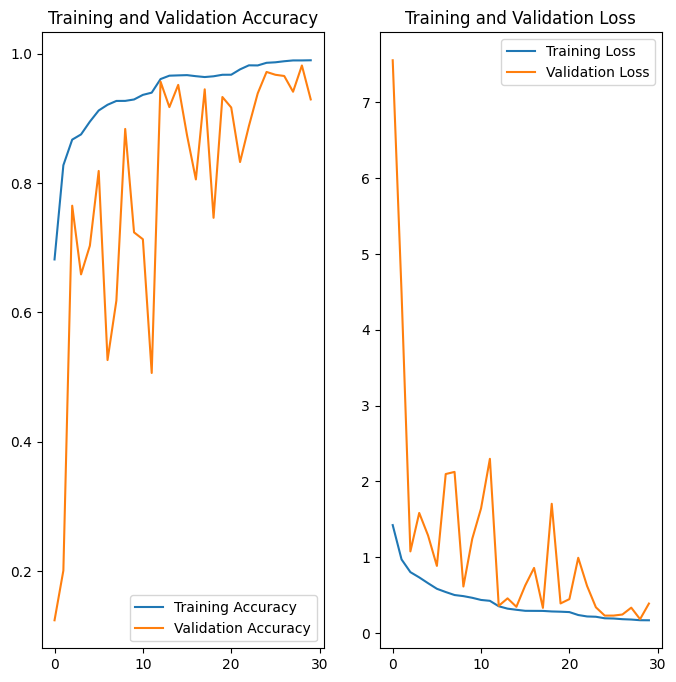

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()